- we have a function to describe the start and end of RS
- we have another function to integrate over small time intervals
- at S we finish the integration and return the final state
- we plot the state based in different t_s samples.
- we plot the std as a function of t_s

- we add noise to integration or the clock samples

In [269]:
""" RSG simple diffusion model simulation """
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import f
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

 

Clock and Integration Measurments

In [270]:
t_min = 100
t_max = 3000
data_number = 5
sample_intervals = np.linspace(t_min, t_max, data_number, dtype=int)

def clock(t_s, noise=False, bias=False):
    """
    Clock function
    :param t_s: time series length
    :return: time series
    """
    change = 0
    if bias:
        change = np.random.normal(0, .2)
        while change <= -1 or change > 1:
            change = np.random.normal(0, .2)

    if not noise:
        dataPoints = np.ones(t_s)
        if change != 0:
            dataPoints = dataPoints + change
    else:
        dataPoints = []
        for _ in range(t_s):
            dataPoint = np.random.normal(1, 1) + change
            while dataPoint <= 0 or dataPoint > 2:
                dataPoint = np.random.normal(1, 1) + change
            dataPoints.append(dataPoint)

    return dataPoints


def time_integral(time_series, noise=False):
    """
    Time integral of a time series
    :param time_series: list of time series
    :return: time integral
    """
    cumulative_series = []
    cumulative_sum = 0
    for moment in time_series:
        if not noise:
            cumulative_sum += moment
        else:
            cumulative_sum += np.random.normal(moment, 1)
        cumulative_series.append(cumulative_sum)
    return cumulative_series

# Simulation and plotting
def color():
    # if condition == 'short':
    #     return 'black'
    # elif condition == 'intermediate':
    #     return 'darkred'
    # elif condition == 'long':
    #     return 'red'
    # else:
    #     raise ValueError('Invalid color condition')
    return 'darkred'


def simulator(repeat, noise=(False, False, False)):
    # Define t_min and t_max based on condition
    # if condition == 'short':
    #     t_min = 494
    #     t_max = 847
    # elif condition == 'intermediate':
    #     t_min = 671
    #     t_max = 1023
    # elif condition == 'long':
    #     t_min = 847
    #     t_max = 1200
    # else:
    #      raise ValueError('Invalid condition')
    # t_min = 494
    # t_max = 1200

    # Generate t_s
    t_s = np.array([s for s in sample_intervals for _ in range(repeat)])

    # Generate t_m based on Gaussian distribution
    time_series = [clock(t, noise[0], noise[1]) for t in t_s]
    cumulative_series = [time_integral(series, noise[2]) for series in time_series]
    state = [series[-1] for series in cumulative_series]
    # Calculate mean for each method
    state_groups = [state[i:i + repeat] for i in range(0, len(state), repeat)]
    mean_state = [np.average(i) for i in state_groups]
    sd_state = [np.std(i) for i in state_groups]
    
    
    return sample_intervals, t_s, state, mean_state, sd_state, state_groups


In [271]:
def plot_simulation(clock_noise=False, clock_bias=False, integration_noise=False):
    
    # clock and time integral plot
    time_series = clock(1200, clock_noise, clock_bias)
    cumulative_series = time_integral(time_series, integration_noise)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    measurments = axes[0][0]
    integral = axes[0][1]
    final_state = axes[1][0]
    deviation = axes[1][1]

    measurments.plot(time_series, color='k')
    measurments.set_xlabel('Time')
    measurments.set_ylabel('Measured moment')
    measurments.set_ylim(-5, 15)
    measurments.set_title('Clock measurements')
    measurments.axhline(1, color='r', linestyle='--', label='True Value')
    measurments.legend()

    integral.plot(cumulative_series, color='k')
    integral.set_xlabel('Time')
    integral.set_ylabel('Cumulative Time')
    integral.set_title('Time Integral')
 
    no_noise_sample_intervals, _, _, no_noise_mean_state, no_noise_sd_state, _ = simulator(1)
    sample_intervals, t_s, state, mean_state, sd_state, _ = simulator(1000, noise=(clock_noise, clock_bias, integration_noise))

    final_state.scatter(t_s, state, color=color(), marker='o', s=4.5, alpha=0.2)
    final_state.plot(sample_intervals, mean_state, color=color(), marker='o', markersize=8, label='With Noise')
    final_state.plot(no_noise_sample_intervals, no_noise_mean_state, color='k', linestyle='--', label='Without Noise')
    final_state.fill_between(sample_intervals, np.array(mean_state) - np.array(sd_state), np.array(mean_state) + np.array(sd_state), color=color(), alpha=0.3)
    final_state.set_title('Mean State')
    final_state.set_xlabel('t_s')
    final_state.set_ylabel('Final State')
    final_state.legend()

    deviation.plot(sample_intervals, sd_state, color=color(), marker='o', markersize=8, label='With Noise')
    deviation.plot(no_noise_sample_intervals, no_noise_sd_state, color='k', linestyle='--', label='Without Noise')
    deviation.set_title('Standard Deviation')
    deviation.set_xlabel('t_s')
    deviation.set_ylabel('Standard Deviation')
    deviation.legend()
    
    fig.suptitle(f'Simulation Data with\nclock noise = {clock_noise}, clock bias = {clock_bias}, integration noise = {integration_noise}')
    plt.show()


In [272]:
# # # Clock noise
# plot_simulation(clock_noise=True)

# # # Clock bias
# plot_simulation(clock_bias=True)

# # # Integration noise
# plot_simulation(integration_noise=True)

# # Clock noise and bias
# plot_simulation(clock_noise=True, clock_bias=True)

# # Clock noise and integration noise
# plot_simulation(clock_noise=True, integration_noise=True)

# # Clock bias and integration noise
# plot_simulation(clock_bias=True, integration_noise=True)

# # Clock noise, bias and integration noise
# plot_simulation(clock_noise=True, clock_bias=True, integration_noise=True)



Production
- set threshold to t_s
- start with clock measurements, stop when threshold reached
- set the time to pass the threshold as the product


In [273]:
old_bias=0
def production_clock(noise=False, bias=False, new_bias=True):
    """
    Clock function
    :param t_s: time series length
    :return: time series
    """
    change = 0
    if bias:
        if new_bias:
            change = np.random.normal(0, .2)
            while change <= -1 or change > 1:
                change = np.random.normal(0, .2)
            global old_bias
            old_bias = change
        else:
            change = old_bias

    if not noise:
        dataPoint = 1 + change
    else:
        dataPoint = np.random.normal(1, 1) + change
        while dataPoint <= 0 or dataPoint > 2:
            dataPoint = np.random.normal(1, 1) + change

    yield dataPoint

def production_integral(threshold, clock_noise=False, clock_bias=False, integration_noise=False):
    """
    Time integral of a time series
    :param time_series: list of time series
    :return: time integral
    """
    cumulative_sum = 0
    time_series = []
    cumulative_series = []
    moment = next(production_clock(clock_noise, clock_bias, True))
    while cumulative_sum < threshold:
        if not integration_noise:
            cumulative_sum += moment
        else:
            cumulative_sum += np.random.normal(moment, 1)
        time_series.append(moment)
        cumulative_series.append(cumulative_sum)
        moment = next(production_clock(clock_noise, clock_bias, False))
    # print(len(cumulative_series))
    return time_series, cumulative_series

In [274]:

def production_simulator(repeat, clock_noise=False, clock_bias=False, integration_noise=False):

    # Generate t_e
    t_e = np.array([s for s in sample_intervals for _ in range(repeat)])
    # print(t_e)

    # Generate t_p based on integrator
    time_series = []
    cumulative_series = []
    for t in t_e:
        time, cumulative = production_integral(t, clock_noise, clock_bias, integration_noise)
        time_series.append(time)
        cumulative_series.append(cumulative)

    t_p = [len(series) for series in cumulative_series]
    # Calculate mean for each method
    t_p_groups = [t_p[i:i + repeat] for i in range(0, len(t_p), repeat)]
    mean_production = [np.average(i) for i in t_p_groups]
    sd_production = [np.std(i) for i in t_p_groups]
    
    
    return time, cumulative, sample_intervals, t_e, t_p, mean_production, sd_production, t_p_groups


In [275]:
def production_plot_simulation(clock_noise=False, clock_bias=False, integration_noise=False):
    
    # clock and time integral plot
    _, _, no_noise_sample_intervals, _, _, no_noise_mean_state, no_noise_sd_state, _ = production_simulator(1)
    time_series, cumulative_series, sample_intervals, t_e, t_p, mean_production, sd_production, _ = production_simulator(1000, clock_noise, clock_bias, integration_noise)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    measurments = axes[0][0]
    integral = axes[0][1]
    final_state = axes[1][0]
    deviation = axes[1][1]

    measurments.plot(time_series, color='k')
    measurments.set_xlabel('Time')
    measurments.set_ylabel('Measured moment')
    # measurments.set_xlim(0, 50)
    measurments.set_ylim(-5, 15)
    measurments.set_title('Clock measurements')
    measurments.axhline(1, color='r', linestyle='--', label='True Value')
    measurments.legend()

    integral.plot(cumulative_series, color='k')
    integral.set_xlabel('Time')
    integral.set_ylabel('Cumulative Time')
    integral.set_title('Time Integral')
 

    final_state.scatter(t_e, t_p, color=color(), marker='o', s=4.5, alpha=0.2)
    final_state.plot(sample_intervals, mean_production, color=color(), marker='o', markersize=8, label='With Noise')
    final_state.plot(no_noise_sample_intervals, no_noise_mean_state, color='k', linestyle='--', label='Without Noise')
    final_state.fill_between(sample_intervals, np.array(mean_production) - np.array(sd_production), np.array(mean_production) + np.array(sd_production), color=color(), alpha=0.3)
    final_state.set_title('Mean t_p')
    final_state.set_xlabel('t_e')
    final_state.set_ylabel('t_p')
    # final_state.set_ylim(0, 2000)
    final_state.legend()

    deviation.plot(sample_intervals, sd_production, color=color(), marker='o', markersize=8, label='With Noise')
    deviation.plot(no_noise_sample_intervals, no_noise_sd_state, color='k', linestyle='--', label='Without Noise')
    deviation.set_title('Standard Deviation')
    deviation.set_xlabel('t_e')
    deviation.set_ylabel('Standard Deviation')
    deviation.legend()
    
    fig.suptitle(f'Simulation Data with\nclock noise = {clock_noise}, clock bias = {clock_bias}, integration noise = {integration_noise}')
    plt.show()


In [276]:
# # Clock noise
# production_plot_simulation(clock_noise=True)

# # Clock bias
# production_plot_simulation(clock_bias=True)

# # Integration noise
# production_plot_simulation(integration_noise=True)

# # Clock noise and bias
# plot_simulation(clock_noise=True, clock_bias=True)

# # Clock noise and integration noise
# plot_simulation(clock_noise=True, integration_noise=True)

# # Clock bias and integration noise
# plot_simulation(clock_bias=True, integration_noise=True)

# Clock noise, bias and integration noise
# production_plot_simulation(clock_noise=True, clock_bias=True, integration_noise=True)



In [277]:
def SD_mean(clock_noise=False, clock_bias=False, integration_noise=False):
    

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    final_state = axes[0]
    deviation = axes[1]

    _, _, no_noise_sample_intervals, _, _, no_noise_mean, no_noise_sd, _ = production_simulator(1)
    state_sample_intervals, t_s, state, mean_state, sd_state, state_groups = simulator(100, noise=(clock_noise, clock_bias, integration_noise))
    _, _, sample_intervals, t_e, t_p, mean_production, sd_production, t_p_groups = production_simulator(100, clock_noise, clock_bias, integration_noise)
    

    
    final_state.scatter(t_s, state, color='darkred', marker='o', s=4, alpha=0.2,)
    final_state.plot(state_sample_intervals, mean_state, color='darkred', marker='o', markersize=7, label='State With Noise')
    final_state.fill_between(state_sample_intervals, np.array(mean_state) - np.array(sd_state), np.array(mean_state) + np.array(sd_state), color='darkred', alpha=0.3)
    deviation.plot(state_sample_intervals, sd_state, color='darkred', marker='o', markersize=7, label='State SD With Noise')
    

    final_state.scatter(t_e, t_p, color='darkblue', marker='o', s=4, alpha=0.2)
    final_state.plot(sample_intervals, mean_production, color='darkblue', marker='o', markersize=7, label='t_p With Noise')
    final_state.plot(no_noise_sample_intervals, no_noise_mean, color='k', linestyle='--', label='Without Noise')
    final_state.fill_between(sample_intervals, np.array(mean_production) - np.array(sd_production), np.array(mean_production) + np.array(sd_production), color='darkblue', alpha=0.3)
    deviation.plot(sample_intervals, sd_production, color='darkblue', marker='o', markersize=7, label='t_p SD With Noise')
    deviation.plot(no_noise_sample_intervals, no_noise_sd, color='k', linestyle='--', label='SD Without Noise')

    p_values = []
    state_groups = [np.array(i) for i in state_groups]
    t_p_groups = [np.array(i) for i in t_p_groups]

    for i in range(len(state_groups)):
        var1 = np.var(state_groups[i], ddof=1)
        var2 = np.var(t_p_groups[i], ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        dfn = state_groups[i].size - 1  # degrees of freedom numerator
        dfd = t_p_groups[i].size - 1  # degrees of freedom denominator
        p_value = 1 - f.cdf(f_stat, dfn, dfd) if var1 > var2 else 1 - f.cdf(f_stat, dfd, dfn)
        p_values.append(p_value * 2)  # Two-tailed test

    for i, p_value in enumerate(p_values):
        if p_value < 0.05:
            deviation.annotate('*', (sample_intervals[i], 1.1 * max(sd_state[i], sd_production[i])), color='red', fontsize=14, ha='center')

    final_state.set_title('State/t_p')
    final_state.set_xlabel('t_s/t_e')
    final_state.set_ylabel('State/t_p')
    final_state.legend()
    final_state.set_ylim(0, 5000)
    deviation.set_title('Standard Deviation')
    deviation.set_xlabel('t_s/t_e')
    deviation.set_ylabel('Standard Deviation')
    deviation.legend()
    deviation.set_ylim(0, max(max(sd_state), max(sd_production)) * 1.2)

    fig.suptitle(f'Simulation Data with\nclock noise = {clock_noise}, clock bias = {clock_bias}, integration noise = {integration_noise}')
    plt.show()


In [278]:
# # Clock noise
# comparison(clock_noise=True)

# # Clock bias
# comparison(clock_bias=True)

# # Integration noise
# comparison(integration_noise=True)


In [279]:
def SD_mean(clock_noise=False, clock_bias=False, integration_noise=False):
    repeat = 100

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    measured = axes[0]
    produced = axes[1]

    _, _, _, no_noise_mean, no_noise_sd, _ = simulator(1)
    _, _, _, mean_state, sd_state, _ = simulator(repeat, noise=(clock_noise, clock_bias, integration_noise))
    

    measured.plot(mean_state, sd_state, color='darkred', marker='o', markersize=7, label='With Noise')
    measured.plot(no_noise_mean, no_noise_sd, color='k', linestyle='--', label='Without Noise')

    measured.set_title('Measurmement Standard Deviation')
    measured.set_xlabel('Mean State')
    measured.set_ylabel('Standard Deviation')
    measured.legend()


    _, _, _, _, _, no_noise_mean, no_noise_sd, _ = production_simulator(1)
    _, _, _, _, _, mean_production, sd_production, _ = production_simulator(repeat, clock_noise, clock_bias, integration_noise)
    
    produced.plot(mean_production, sd_production, color='darkblue', marker='o', markersize=7, label='With Noise')
    produced.plot(no_noise_mean, no_noise_sd, color='k', linestyle='--', label='Without Noise')

    produced.set_title('Production Standard Deviation')
    produced.set_xlabel('Mean State')
    produced.set_ylabel('Standard Deviation')
    produced.legend()

    fig.suptitle(f'SD dependency with\nclock noise = {clock_noise}, clock bias = {clock_bias}, integration noise = {integration_noise}')
    plt.show()


In [280]:
# # Clock noise
# SD_mean(clock_noise=True)

# # Clock bias
# SD_mean(clock_bias=True)

# # Integration noise
# SD_mean(integration_noise=True)


Distribution of data

In [281]:
def distribution(clock_noise=False, clock_bias=False, integration_noise=False):
    repeat = 10000
    _, _, _, _, _, m_state_groups = simulator(repeat, noise=(clock_noise, clock_bias, integration_noise))
    _, _, _, _, _, _, _, p_state_groups = production_simulator(repeat, clock_noise, clock_bias, integration_noise)

    for index in range(data_number):
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        measured = axes[0]
        produced = axes[1]

        ev = sample_intervals[index]

        measured.hist(m_state_groups[index], bins=50 ,alpha=.8, color='darkred')
        measured.axvline(ev, color='k', linestyle='--', label=f't_s = {ev}')
        measured.set_title('Measurement Distribution')
        measured.set_xlabel('Final State')
        measured.set_ylabel('Frequency')
        measured.legend()
        
        produced.hist(p_state_groups[index], bins=50, alpha=.8, color='darkblue')
        produced.axvline(ev, color='k', linestyle='--', label=f't_e = {ev}')
        produced.set_title('Production Distribution')
        produced.set_xlabel('t_p')
        produced.set_ylabel('Frequency')
        produced.legend()

        fig.suptitle(f'Distribution of data with\nclock noise = {clock_noise}, clock bias = {clock_bias}, integration noise = {integration_noise}')
        plt.show()

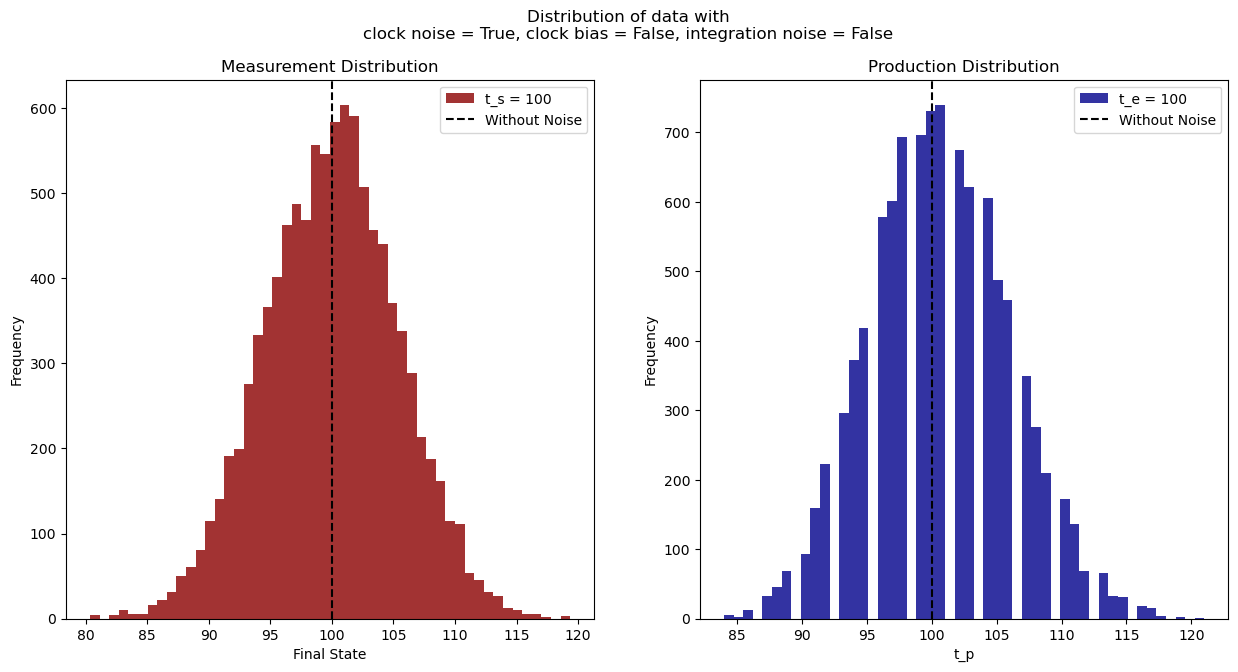

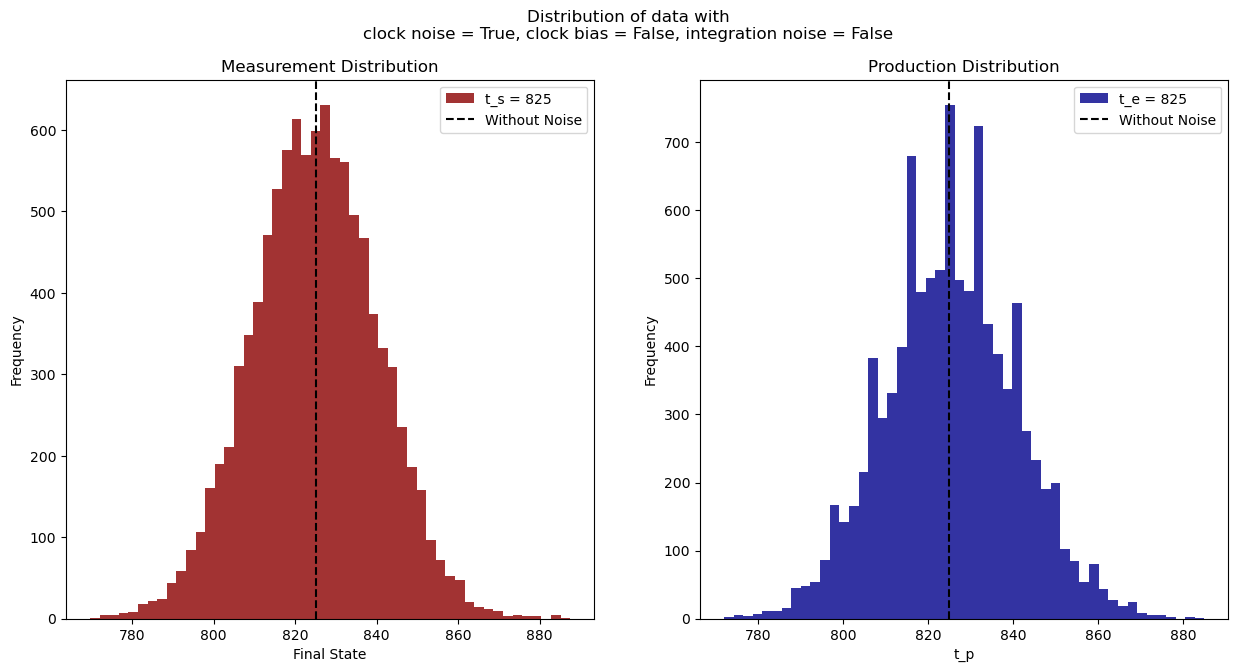

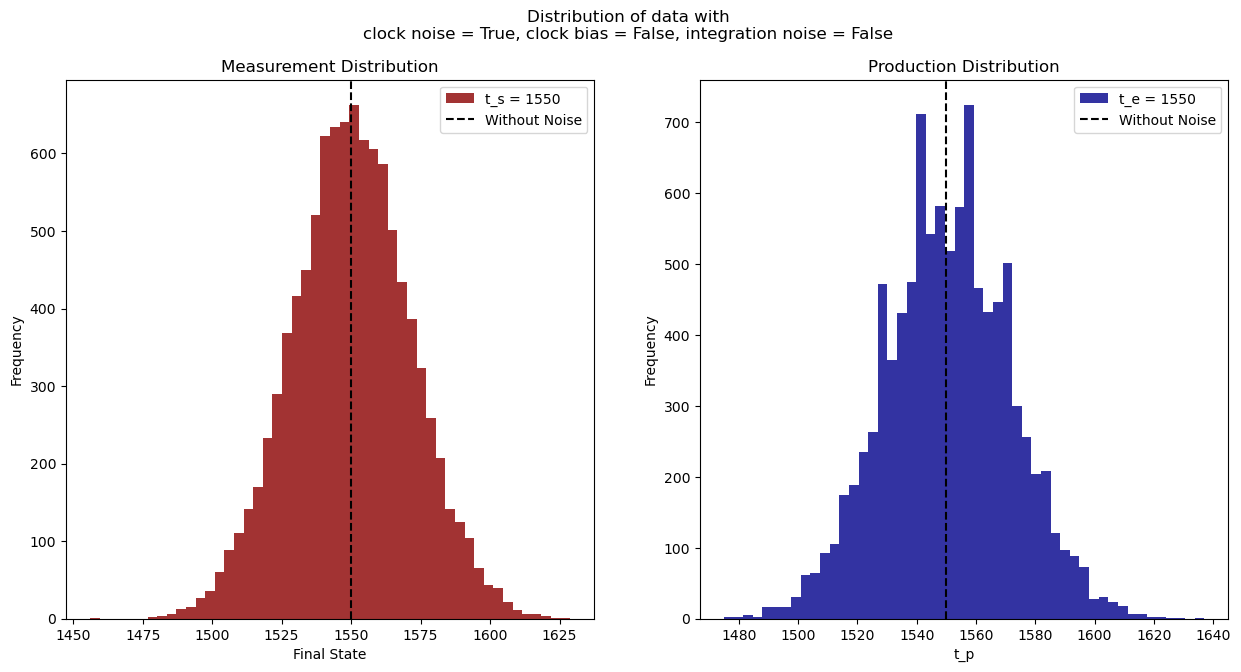

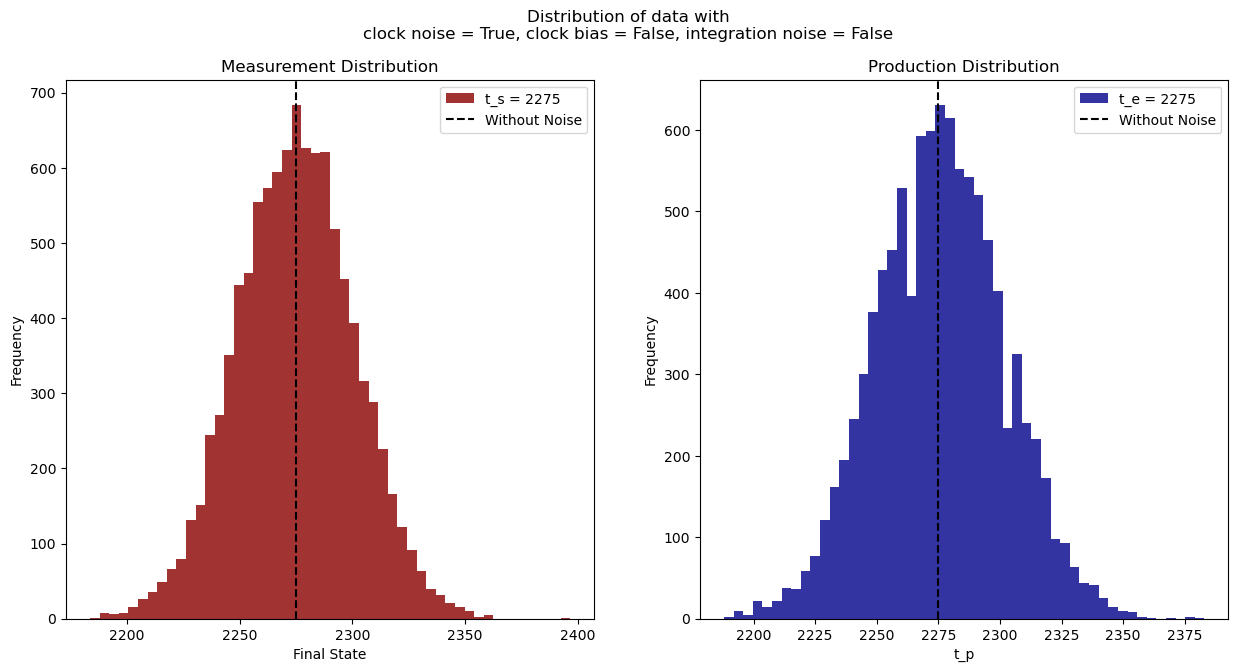

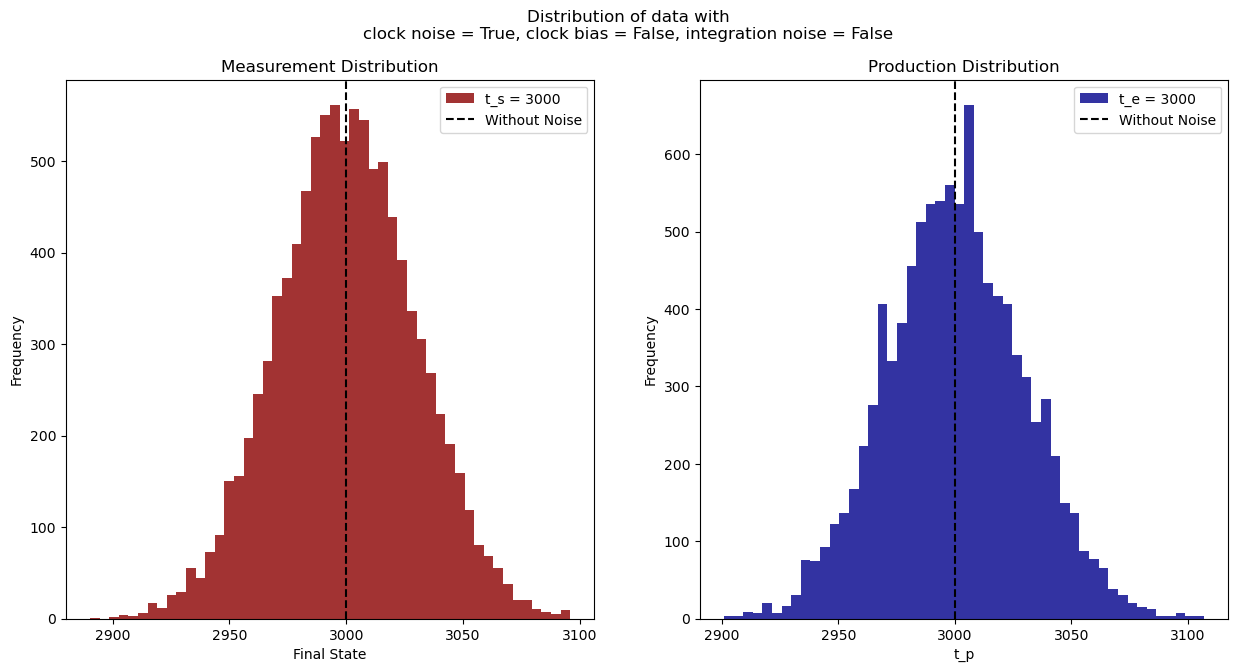

In [282]:
distribution(clock_noise=True)


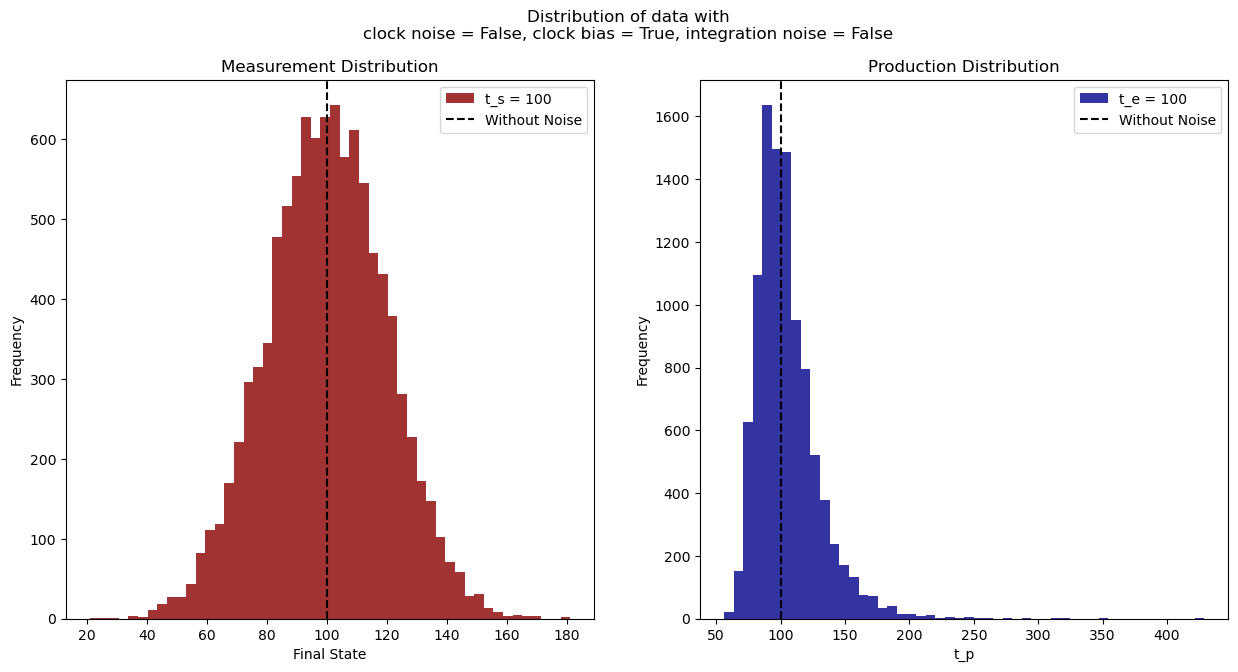

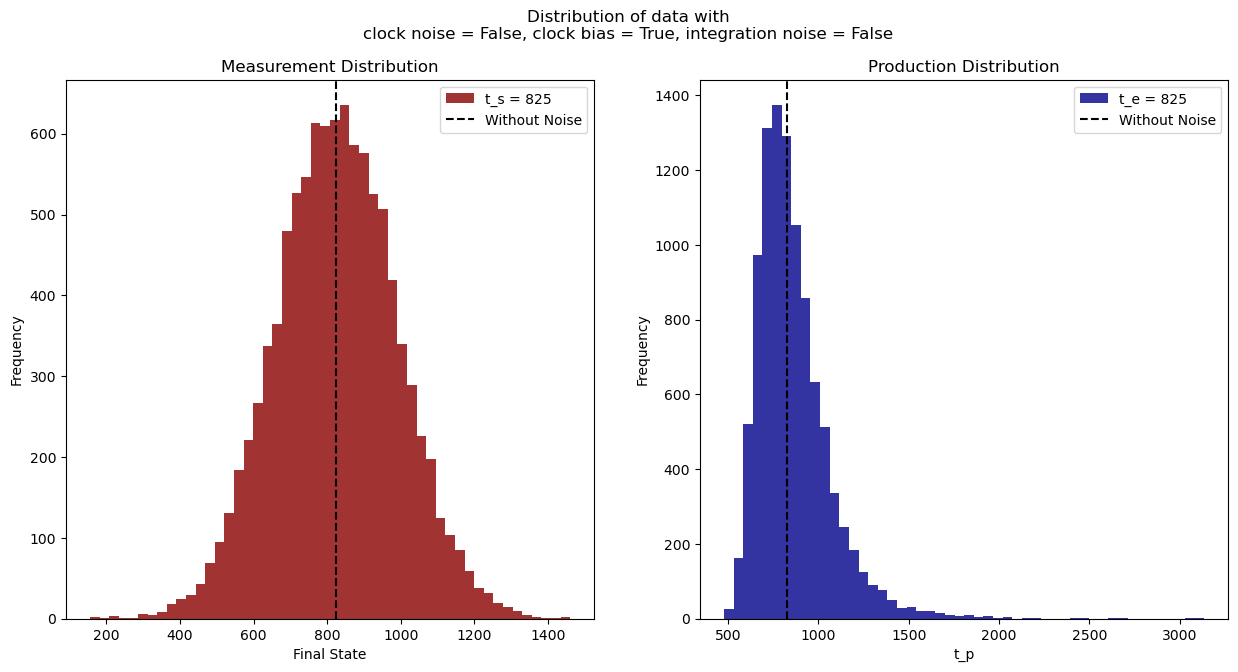

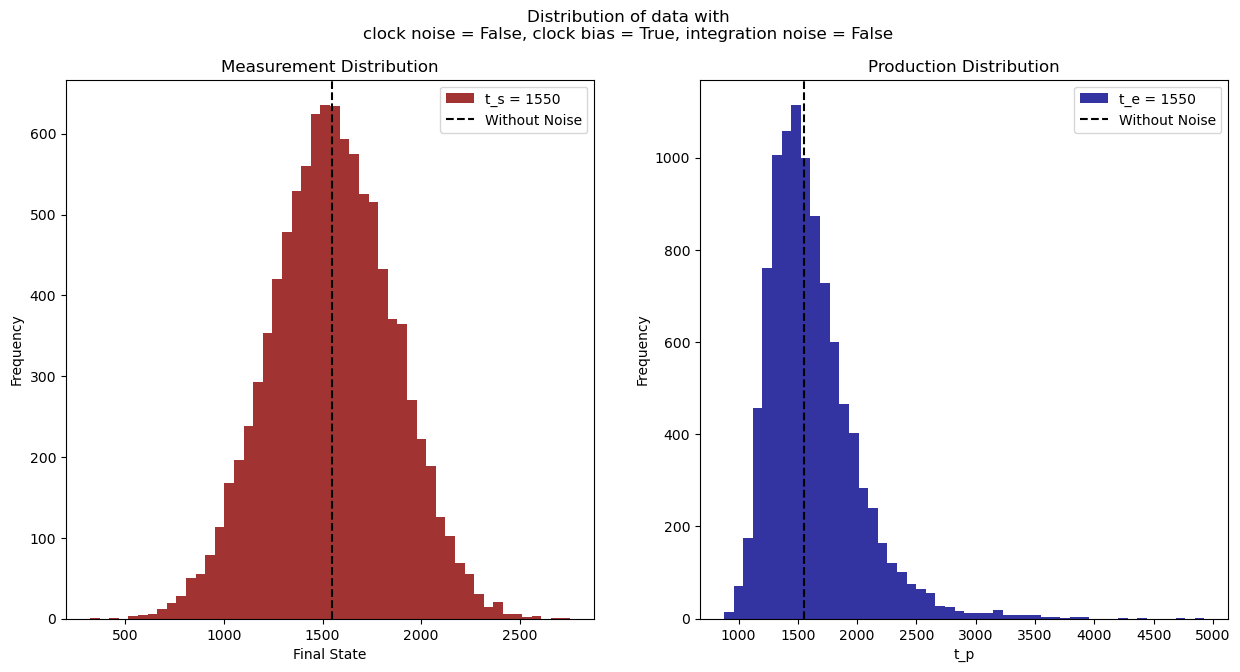

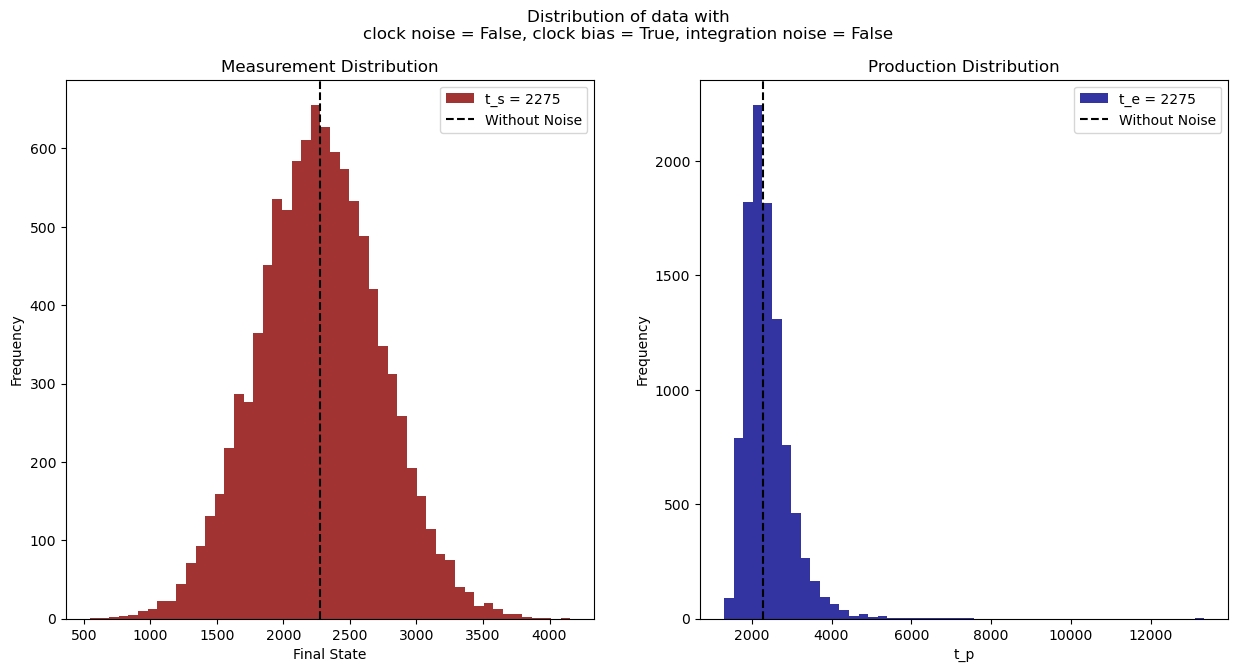

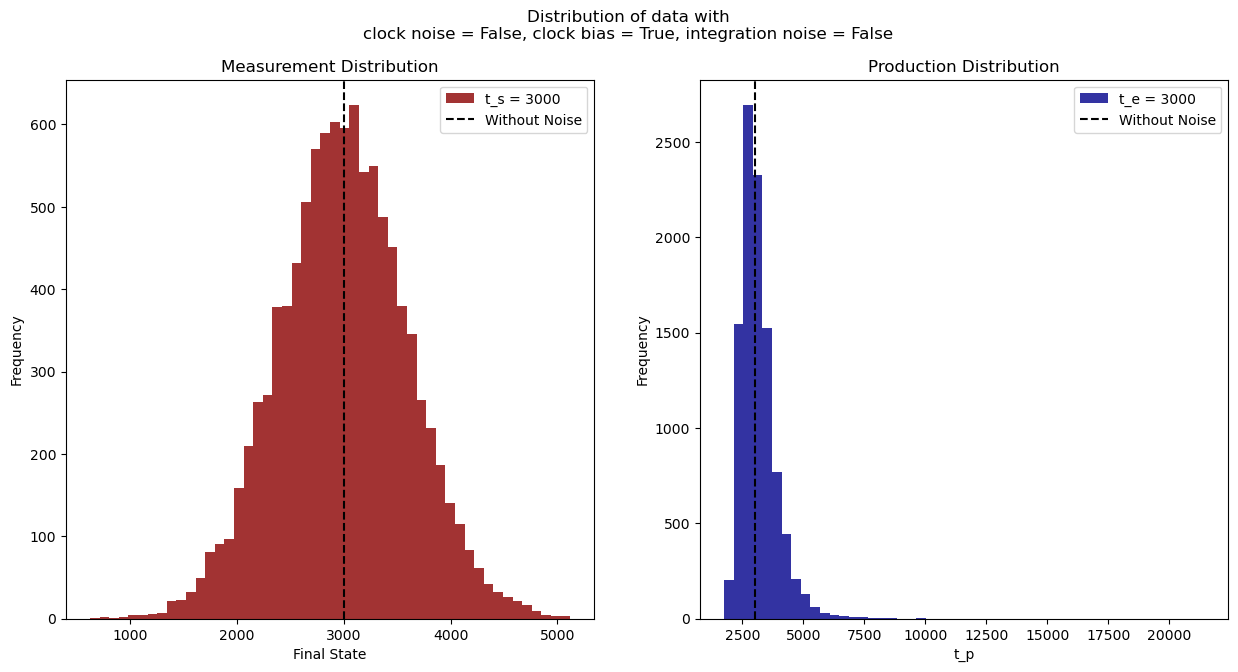

In [283]:
distribution(clock_bias=True)


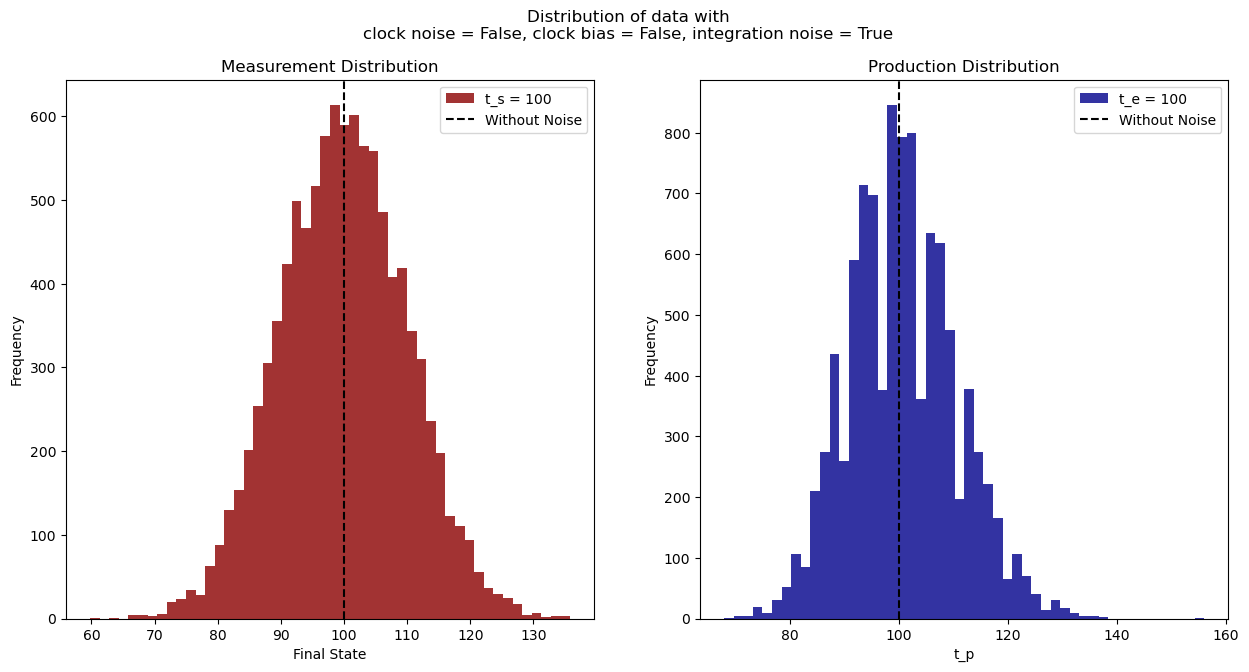

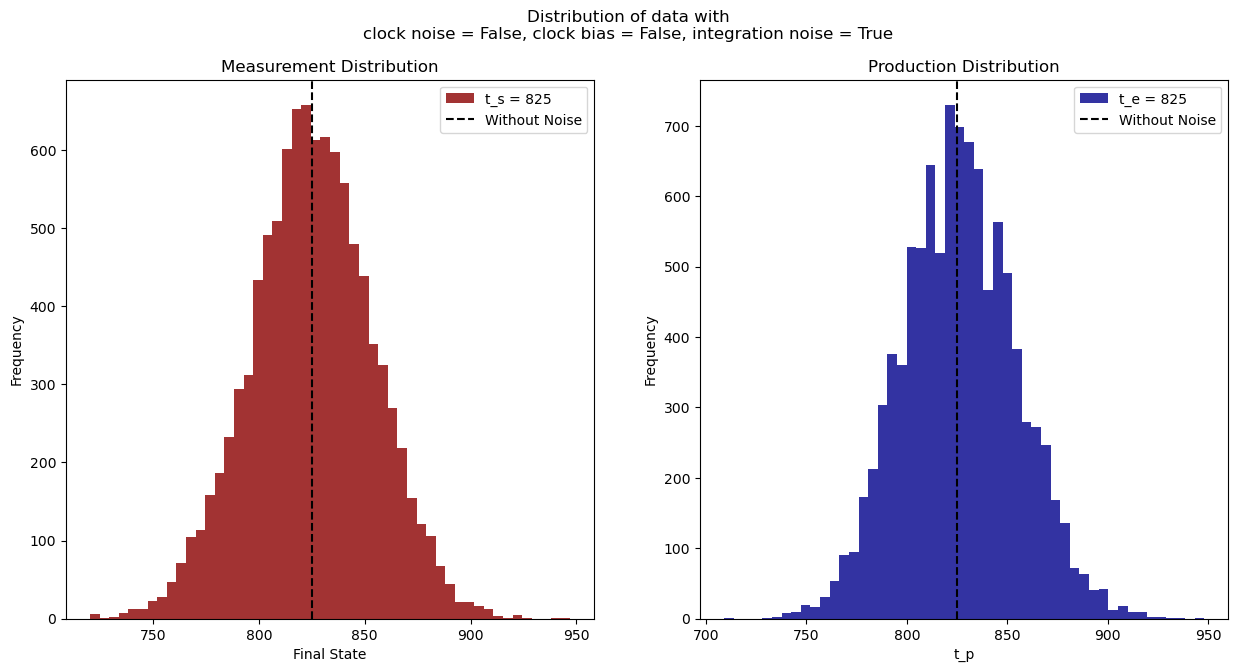

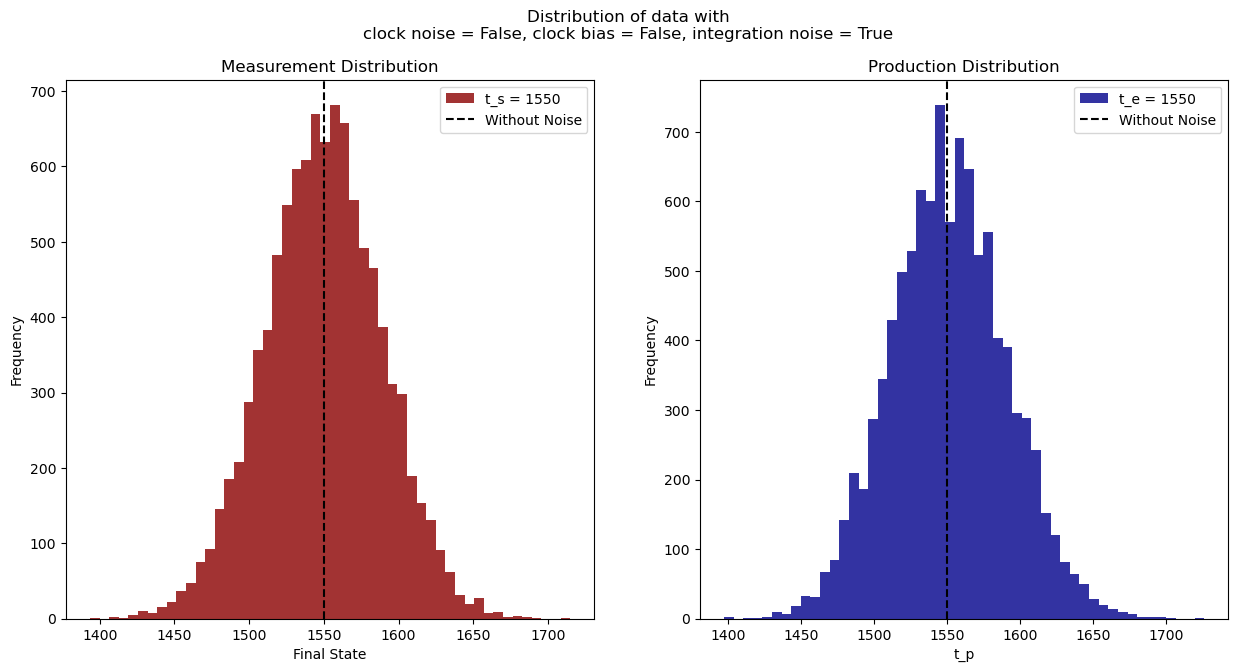

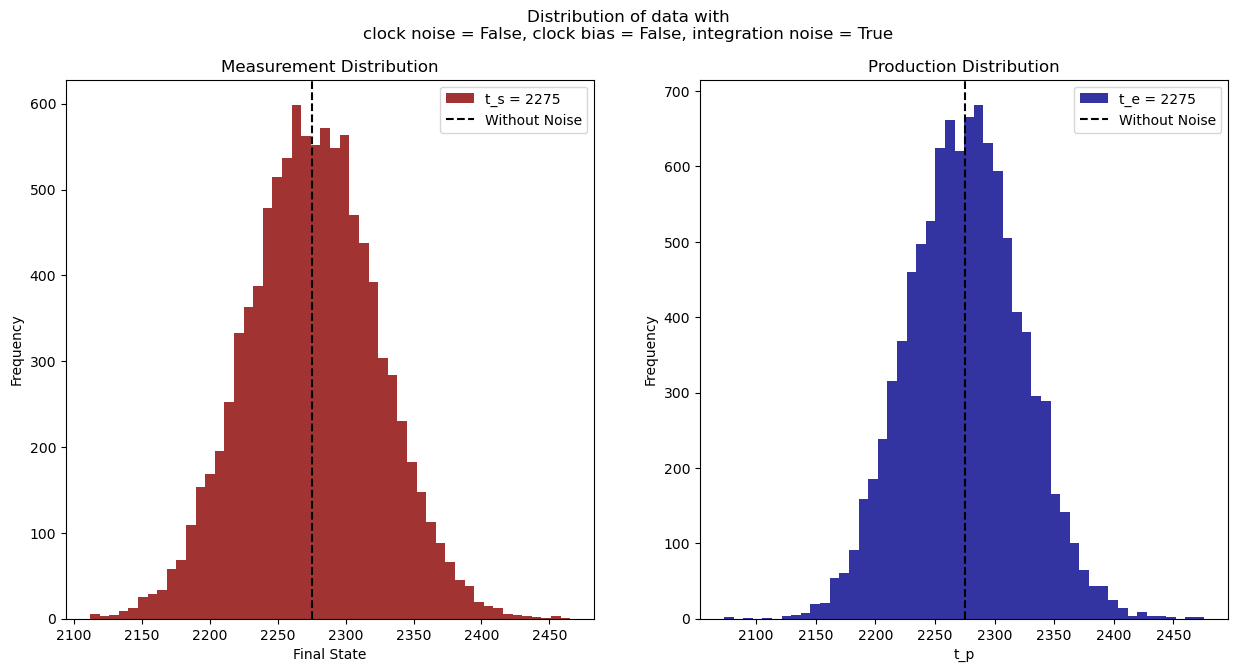

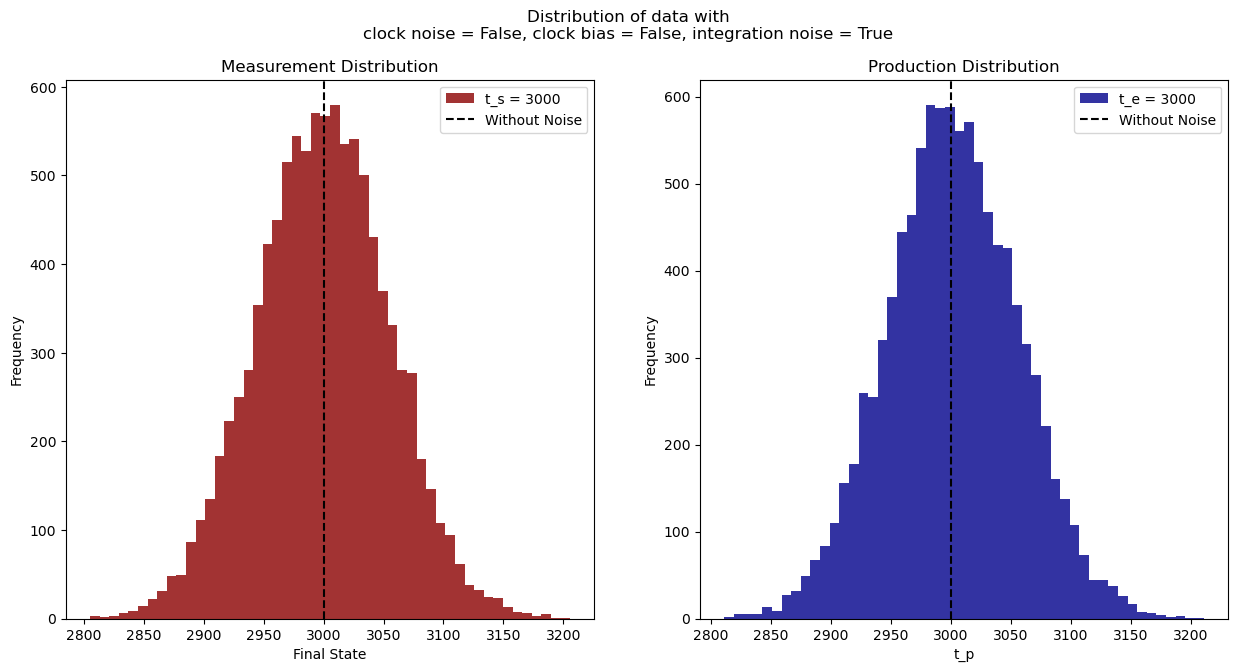

In [284]:
distribution(integration_noise=True)
